# Wikipedia's Weekly List of Top Articles

The code below produces the weekly visuaization of the top articles that is used for the report published on https://en.wikipedia.org/wiki/Wikipedia:Top_25_Report

Here is what it does: 
1. Import this week's top 25 table
2. Import the previous week's top 25 table
3. Compare the current table to the previous one, and create two columns. The first, showing whether or not an entry is new, going up, going down, or at the same level compared to the previous week. The second column translates the newly-created column into symbols; ('▲', '▼', '▶', 'new'), colored green, red, or black, signifying up, down, or same level. 
4. Plot the values using a horizontal bar char, coloring the entry labels with their respective colors. 
5. Save the chart to a file ready for upload.

To create the chart, simply place the cursor inside the following code cell, and then hit the 'play' button above.

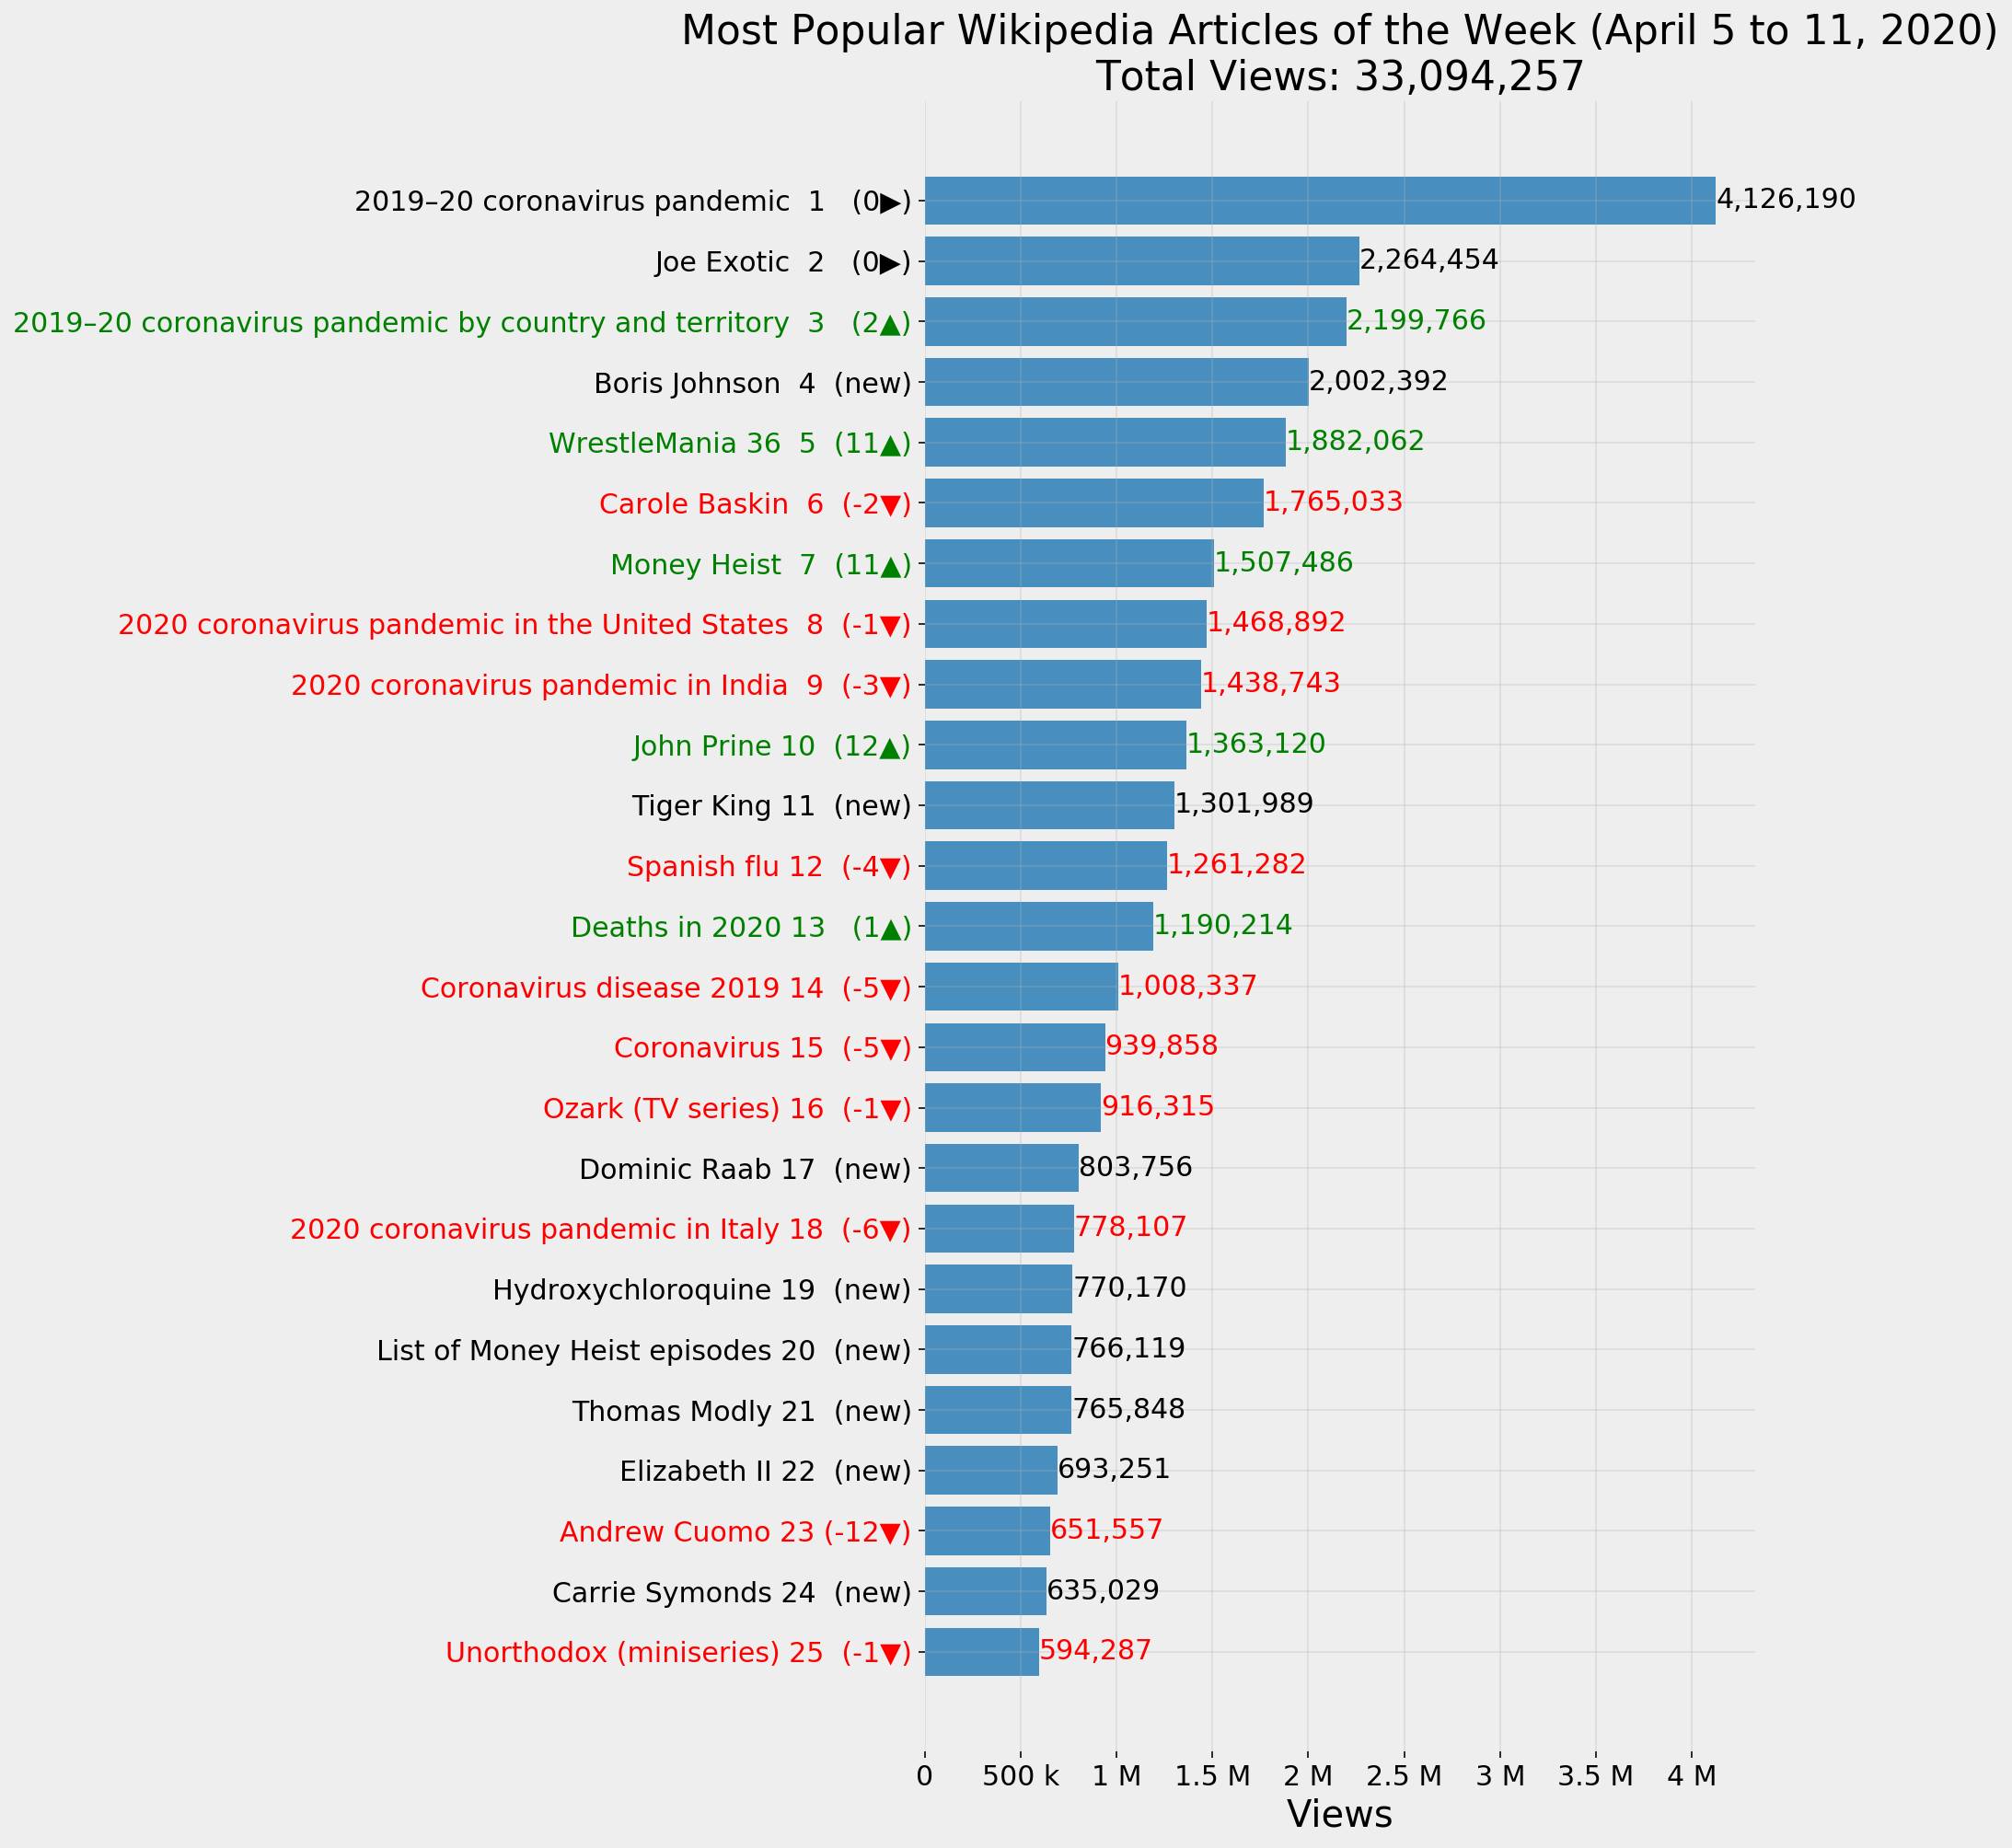

In [2]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

import pandas as pd
import requests
from bs4 import BeautifulSoup

page = 'https://en.wikipedia.org/wiki/Wikipedia:Top_25_Report'
resp_this_week = requests.get(page)

soup_this_week = BeautifulSoup(resp_this_week.text, 'lxml')
page_links = soup_this_week.find_all('a')
uri_last_week = [p for p in page_links if "Last week's report" in p.text][0]['href']
url_last_week = 'https://en.wikipedia.org' + uri_last_week

this_week = pd.read_html(page, header=0)[2]
last_week = pd.read_html(url_last_week, header=0)[2]

this_week['Views'] = this_week['Views'].astype(str).str.replace('\D+', '').astype(int)
last_week['Views'] = last_week['Views'].astype(str).str.replace('\D+', '').astype(int)

rank_changes = []
for rank, article in zip(this_week['Rank'], this_week['Article']):
    if article in last_week['Article'].values:
        rank_changes.append(last_week['Article'].values.tolist().index(article)+1-rank)
    else:
        rank_changes.append('')

top25 = this_week
top25['rank_changes'] = rank_changes

arrows = {
    'positive': 9650,
    'negative': 9660,
    'same': 9654,
}  

rank_changes_chr = []
for rank in top25['rank_changes']:
    if str(rank) == '0':
        rank_changes_chr.append(chr(arrows['same']))
    elif not rank:
        rank_changes_chr.append('new')
    elif str(rank) < '0':
        rank_changes_chr.append(chr(arrows['negative']))
    elif '0' < str(rank): # < '25':
        rank_changes_chr.append(chr(arrows['positive']))

rank_changes_color = []
for rank in top25['rank_changes']:
    if str(rank) == '0':
        rank_changes_color.append('black')
    elif not rank:
        rank_changes_color.append('black')
    elif str(rank) < '0':
        rank_changes_color.append('red')
    elif '0' < str(rank):
        rank_changes_color.append('green')
                
top25['rank_changes_chr'] = rank_changes_chr
top25['rank_changes_color'] = rank_changes_color
fig, ax = plt.subplots()
fig.set_size_inches(14, 14)
fig.set_facecolor('#eeeeee')
ax.set_facecolor('#eeeeee')
ax.set_frame_on(False)
ax.grid(alpha=0.3)

y_text = (
    top25['Article'][::-1].astype(str) + 
    top25['Rank'][::-1].astype(str).str.rjust(3) +
    ('(' + top25['rank_changes'][::-1].astype(str)  + top25['rank_changes_chr'][::-1].astype(str) + ')').str.rjust(7, ' ')
)

ax.barh(y=y_text,
         width=top25['Views'][::-1], alpha=0.8)
ax.xaxis.set_major_formatter(EngFormatter())
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

for i in range(25):
    ax.text(x=top25['Views'][i],
            y=y_text.values[::-1][i],
            s='{:,}'.format(top25['Views'][i]),
            color=top25['rank_changes_color'][i],            
            horizontalalignment='left',
            verticalalignment='center', fontsize=15)

colors = top25['rank_changes_color'][::-1]
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)
        
ax.set_xlabel('Views', fontsize=20)
ax.set_title(soup_this_week.select('h2 .mw-headline')[0].text +
             '\nTotal Views: ' + format(top25['Views'].sum(), ','),
          fontsize=22)
plt.tight_layout()
fig.savefig(soup_this_week.select('h2 .mw-headline')[0].text + '.png', 
            facecolor='#eeeeee', dpi=150, bbox_inches='tight')
plt.show()

## Optional: Tweet the chart!

This code creates a tweet that has a link to the report on Wikipedia, and creates hashtags of the top topics, making sure they fit in a tweet's maximum of 280 characters

In [2]:
import re

title = soup_this_week.select('h2 .mw-headline')[0].text
title = re.sub('\(|\)|\.', '', title).replace('Wiki', '@Wiki')

wiki_url = 'http://bit.ly/wikitop25'
hashtags = '#' + top25['Article'].str.replace(' |\(|\)|-|–|!|,|:|\.|\'', '')
headers_len = len(title + '\n' + wiki_url + '\n\n')

remaining_len = 280 - headers_len
last_space = ' '.join(hashtags)[:remaining_len].rfind(' ')

tweet_text = title + '\n' + wiki_url + '\n\n' + '\n'.join(hashtags)[:last_space]
print(tweet_text)
